In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import numpy as np
from copy import deepcopy
from sklearn.metrics import mean_squared_error

/home/wcx/multiresolution_forecasting/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Benchmarks
Please replace the variable ```pth``` into your new result.

## 1. No adjusts

In [2]:
# electricity load dataset (persistence: loop)
# pth = "results/mfred/example_benchmarks-20230831-041824"

# wind power dataset (persistence: naive)
pth = "results/nrel/example_benchmarks-20230817-231811"
# pth = "results/mfred/example_benchmarks-20230814-210128"

# NL with one large Laplace decoder (failure)
# pth = "results/mfred/example_benchmarks-20231012-175829"

# model_names = ['Neural Laplace', 'LSTM', 'MLP']
model_names = ['Neural Laplace', 'LSTM', 'MLP', 'Persistence']
# model_names = ['Neural Laplace']
fcst_features = [0]
all_seed_result = []
all_seed_preds = []
for seed in range(20):
    with open(f"{pth}-{seed}.pkl", "rb") as f:
        all_result = pickle.load(f)
    test_result = {name: {} for name in model_names}
    test_preds_trajs = {name: {} for name in model_names}
    for avg_terms in all_result:
        result_avg = all_result[avg_terms]
        train_mean = result_avg['train_mean'][fcst_features]
        train_std = result_avg['train_std'][fcst_features]
        num_avg_terms = int(avg_terms.split("_")[-1])
        for name in model_names:
            model_results = result_avg[name]

            test_preds = model_results["test_preds"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()
            test_trajs = model_results["test_trajs"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()
            pred_timesteps = test_trajs.shape[1]
            # if num_avg_terms == 1:
            #     fig, ax = plt.subplots()
            #     ax.plot(test_trajs[300,:,0], label="real")
            #     ax.plot(test_preds[300,:,0], label="fcst")
            #     ax.legend()
            #     ax.set(xlabel="Forecasting horizon", ylabel="Load(kW)")
            #     # ax.set_title(name)
            #     fig.savefig("savings/supp_NL.pdf")
            test_result[name][num_avg_terms] = mean_squared_error(
                test_trajs.squeeze(), test_preds.squeeze(), squared=False)
            test_preds_trajs[name][num_avg_terms] = deepcopy(
                (test_preds, test_trajs))
    df_test_result = pd.DataFrame(test_result)
    all_seed_preds.append(test_preds_trajs)
    all_seed_result.append(df_test_result)
all_seed_result = pd.concat(all_seed_result, axis=0)
all_seed_result = all_seed_result.groupby(all_seed_result.index).agg(
    ["mean", "std"])
all_seed_result = all_seed_result.sort_index()
avg_terms_list = all_seed_result.index.tolist()
all_seed_result
# with open(f'savings/bench_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
#     pickle.dump(all_seed_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

Neural Laplace                LSTM                MLP             
             mean       std      mean      std      mean       std   
1        4.936882  0.380235  5.188830  0.09685  5.149303  0.091195  \
3        4.971793  0.267169  5.307560  0.19586  4.927910  0.118691   
12       4.998867  0.349172  5.403205  0.15979  4.680242  0.086694   

   Persistence       
          mean  std  
1     6.596242  0.0  
3     6.603842  0.0  
12    6.640212  0.0

mean consistent error

In [3]:
max_avg_terms = max(avg_terms_list)
mce_results = {name: [] for name in model_names}
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    for name in model_names:
        mce = {"5min vs 15min":0, "5min vs 60min":0, "15min vs 60min":0}
        for n, avg_terms in enumerate(avg_terms_list):

            if avg_terms < max_avg_terms:
                # print("current avg_terms", avg_terms)
                rest_avg_terms = avg_terms_list[n + 1:]
                (test_preds, test_trajs) = preds_trajs_dict[name][avg_terms]
                for r_avg_terms in rest_avg_terms:
                    (real_avg_preds,
                     real_avg_trajs) = preds_trajs_dict[name][r_avg_terms]
                    # print(avg_terms, r_avg_terms)
                    # calculate predictions
                    avg_test_preds = np.split(test_preds,
                                              test_preds.shape[1] //
                                              (r_avg_terms // avg_terms),
                                              axis=1)
                    avg_test_preds = np.stack(
                        [j.mean(axis=1) for j in avg_test_preds], axis=1)
                    error = (avg_test_preds - real_avg_preds)**2
                    mce[f"{avg_terms*5}min vs {r_avg_terms*5}min"] += error.mean()
        # mce = pd.DataFrame(mce, index=0)
        # print(mce)
        mce_results[name].append(mce)

all_model_mce = []
for name in model_names:
    
    model_mce = pd.DataFrame(mce_results[name]).mean()
    all_model_mce.append(model_mce)
all_model_mce = pd.concat(all_model_mce, axis=1)
all_model_mce = all_model_mce.T
all_model_mce.index = model_names
all_model_mce = all_model_mce.drop("Persistence", axis=0)
all_model_mce
# mce_results.index = [0 for _ in range(20)]
# mce_results = mce_results.groupby(mce_results.index).agg(
    # ["mean", "std"])
# mce_results.index= ["MCE"]
# mce_results.mean()
# mce_results.to_csv(f"savings/bench_{pth.split('/')[1]}_mce.csv")

,5min vs 15min,5min vs 60min,15min vs 60min
Neural Laplace,6.425709,7.581275,7.389087
LSTM,2.006866,5.986436,5.944163
MLP,2.083820,3.931973,2.498962


## 2. After adjusted

### 2.1 Bottom up

In [4]:
all_bu_results, all_bu_preds = [], []
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    bu_results = {name + "-BU": {} for name in model_names}
    bu_preds = {name + "-BU": {} for name in model_names}
    for name in model_names:
        for avg_terms in avg_terms_list:
            (test_preds, test_trajs) = preds_trajs_dict[name][1]
            # Test trajs are consistent
            avg_test_trajs = np.split(test_trajs,
                                      test_trajs.shape[1] // avg_terms,
                                      axis=1)
            avg_test_trajs = np.stack([j.mean(axis=1) for j in avg_test_trajs],
                                      axis=1)

            # calculate predictions
            avg_test_preds = np.split(test_preds,
                                      test_preds.shape[1] // avg_terms,
                                      axis=1)
            avg_test_preds = np.stack([j.mean(axis=1) for j in avg_test_preds],
                                      axis=1)
            bu_results[name + "-BU"][avg_terms] = mean_squared_error(
                avg_test_trajs.flatten(),
                avg_test_preds.flatten(),
                squared=False)
            bu_preds[name + "-BU"][avg_terms] = (avg_test_preds,avg_test_trajs
                                                 )

            # if avg_terms == 3:
            # fig, ax = plt.subplots()
            # ax.plot(avg_test_trajs[0,:,0])
            # ax.plot(avg_test_preds[0,:,0])

    bu_results = pd.DataFrame(bu_results)
    all_bu_results.append(bu_results)
    all_bu_preds.append(bu_preds)
all_bu_results = pd.concat(all_bu_results, axis=0)
all_bu_results = all_bu_results.groupby(all_bu_results.index).agg(
    ["mean", "std"])
all_bu_results = all_bu_results.sort_index()
all_bu_results
# with open(f'savings/bench_bu_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
#     pickle.dump(all_bu_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
# all_bu_results.to_csv("savings/benchmark_bu.csv")


Neural Laplace-BU             LSTM-BU              MLP-BU             
                mean       std      mean       std      mean       std   
1           4.994273  0.405666  5.317320  0.103603  5.214271  0.093587  \
3           4.987119  0.406156  5.306487  0.104206  5.191459  0.092432   
12          4.927970  0.410021  5.250381  0.105409  5.129826  0.092773   

   Persistence-BU       
             mean  std  
1        6.884816  0.0  
3        6.879671  0.0  
12       6.837363  0.0

### 2.2 Optimized

Athanasopoulos, George, et al. "Forecasting with temporal hierarchies." European Journal of Operational Research 262.1 (2017): 60-74.

In [5]:
from scipy.linalg import block_diag

S = [
    block_diag(*[[1.0 / s for _ in range(s)]
                 for _ in range(pred_timesteps // s)]) for s in avg_terms_list
]
S.reverse()
S = np.concatenate(S)
S = S @ np.linalg.inv(S.T @ S) @ S.T

all_opt_results, all_opt_preds = [], []
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    opt_results = {name + "-OPT": {} for name in model_names}
    opt_preds = {name + "-OPT": {} for name in model_names}
    for name in model_names:
        preds_vec, trajs_vec, pred_steps = [], [], []
        for avg_terms in avg_terms_list[::-1]:
            (test_preds, test_trajs) = preds_trajs_dict[name][avg_terms]
            preds_vec.append(test_preds.copy())
            trajs_vec.append(test_trajs.copy())
        preds_vec = np.concatenate(preds_vec, axis=1)
        # preds_vec = preds_vec.transpose(1, 0, 2)
        adjusted_preds = np.tensordot(S, preds_vec, axes=[1, 1])
        start = 0
        for i, trajs in enumerate(trajs_vec):
            steps = trajs.shape[1]
            opt_results[name +
                        "-OPT"][avg_terms_list[::-1][i]] = mean_squared_error(
                            trajs.flatten(),
                            adjusted_preds[start:start + steps,
                                           ...].transpose(1, 0, 2).flatten(),
                            squared=False)
            opt_preds[name + "-OPT"][avg_terms_list[::-1][i]] = (
                adjusted_preds[start:start + steps, ...].transpose(1, 0,
                                                                   2), trajs)
            # if i == 0:
            #     fig, ax = plt.subplots()
            #     ax.plot(trajs[0].flatten())
            #     ax.plot(adjusted_preds[start:start + steps, 0, :].flatten())
            #     print(adjusted_preds[start:start + steps, 0, :].flatten())
            start += steps

    opt_results = pd.DataFrame(opt_results)
    all_opt_results.append(opt_results)
    all_opt_preds.append(opt_preds)

all_opt_results = pd.concat(all_opt_results, axis=0)
all_opt_results = all_opt_results.groupby(all_opt_results.index).agg(
    ["mean", "std"])
all_opt_results = all_opt_results.sort_index()
# all_opt_results.to_csv("savings/benchmark_opt.csv")
# with open(f'savings/bench_opt_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
#     pickle.dump(all_opt_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
all_opt_results

Neural Laplace-OPT            LSTM-OPT             MLP-OPT             
                 mean       std      mean       std      mean       std   
1            4.860383  0.331628  5.299112  0.091206  5.089091  0.076269  \
3            4.853041  0.332068  5.288247  0.091614  5.065711  0.075272   
12           4.792563  0.335591  5.231973  0.092663  5.003829  0.075829   

   Persistence-OPT       
              mean  std  
1         6.883998  0.0  
3         6.878853  0.0  
12        6.836540  0.0

# Hierarchical NL

Please replace the variable ```pth``` into your new result.

In [6]:
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd


# Load
# pth = "results/mfred/example-20230815-052223"

# Wind
pth = "results/nrel/example-20230819-070441"


all_seed_result = []
all_seed_preds = []
fcst_features = [0]
for seed in range(20):
    with open(f"{pth}-{seed}.pkl", "rb") as f:
        result = pickle.load(f)
        avg_terms_list = result["model_hyperparams"]["avg_terms_list"]
        # print(result["model_hyperparams"]["encoder"])
        train_mean = result["train_mean"][fcst_features].detach().cpu().numpy()
        train_std = result["train_std"][fcst_features].detach().cpu().numpy()

        model = result["Hierarchical NL"]
        # avg_terms_list = result["avg_terms_list"]
        # print(result["train_mean"])
        # print(result["train_std"])
        test_label = model["test_trajs"]
        test_preds = model["test_preds"]
        test_label = test_label
        test_label = test_label * train_std + train_mean
        pred_timesteps = test_label.shape[1]

    avg_test_label, avg_test_preds, rmse = {}, {}, {}
    for i, avg_terms in enumerate(avg_terms_list):
        temp = np.split(test_label, test_label.shape[1] // avg_terms, axis=1)
        temp = np.stack([j.mean(axis=1) for j in temp], axis=1)
        avg_test_label[avg_terms] = temp
        # avg_test_preds[avg_terms] = (test_preds[i].detach().cpu().numpy(
        # ), temp)
        avg_test_preds[avg_terms] = (
            test_preds[i].detach().cpu().numpy() * train_std + train_mean,
            temp)

        # print(avg_test_preds[avg_terms][0].flatten())
        rmse[avg_terms] = [
            mean_squared_error(temp.squeeze(),
                               avg_test_preds[avg_terms][0].squeeze(),
                               squared=False)
        ]
        # fig, ax = plt.subplots()
        # ax.plot(temp[3,:,0])
        # ax.plot(avg_test_preds[avg_terms][0][3,:,0])
    rmse = pd.DataFrame(rmse).transpose()
    all_seed_result.append(rmse)
    all_seed_preds.append(avg_test_preds)
all_seed_result = pd.concat(all_seed_result, axis=0)
all_seed_result = all_seed_result.groupby(all_seed_result.index).agg(
    ["mean", "std"])
avg_terms_list = all_seed_result.index.tolist()
all_seed_result = all_seed_result.rename(columns={0: "Hierarchical NL"})
all_seed_result

# with open(f'savings/proposed_20_{pth.split("/")[1]}.pickle', 'wb') as handle:
#     pickle.dump(all_seed_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

Hierarchical NL          
              mean       std
1         4.641777  0.252007
3         4.616905  0.248384
12        4.538334  0.250710

mean consistence error

In [7]:
max_avg_terms = max(avg_terms_list)
mce_results = {}
for seed in range(20):
    preds_trajs_dict = all_seed_preds[seed]
    mce = {"5min vs 15min":0, "5min vs 60min":0, "15min vs 60min":0}
    for n, avg_terms in enumerate(avg_terms_list):

        if avg_terms < max_avg_terms:
            # print("current avg_terms", avg_terms)
            rest_avg_terms = avg_terms_list[n + 1:]
            test_preds, _ = preds_trajs_dict[avg_terms]
            for r_avg_terms in rest_avg_terms:
                real_avg_preds, _ = preds_trajs_dict[r_avg_terms]

                # print(avg_terms, r_avg_terms)
                # calculate predictions
                avg_test_preds = np.split(test_preds,
                                          test_preds.shape[1] //
                                          (r_avg_terms // avg_terms),
                                          axis=1)
                avg_test_preds = np.stack(
                    [j.mean(axis=1) for j in avg_test_preds], axis=1)
                error = (avg_test_preds - real_avg_preds)**2
                mce[f"{avg_terms*5}min vs {r_avg_terms*5}min"] += error.mean()
    mce_results[seed] = mce
    # mce_results[seed] = [mce]
mce_results = pd.DataFrame(mce_results)
mce_results.index.name = "seed"
mce_results = mce_results.transpose()
print(mce_results)
# mce_results.columns=["Hierarchical NL"]
# mce_results.index = [0 for _ in range(20)]
mce_results = mce_results.mean()
# mce_results.index= ["MCE"]
all_model_mce = pd.concat([all_model_mce.T, mce_results], axis=1)
all_model_mce.rename(columns={0:"HL"}, inplace=True)
all_model_mce
# hnl = pd.concat([all_seed_result, mce_results])
# benchmarks = pd.read_csv("savings/benchmark_raw.csv", index_col=0, header=[0,1])
# benchmarks.index = hnl.index
# all_results = pd.concat([benchmarks, hnl], axis=1)
# print(all_results)
# mce_results.to_csv(f"savings/proposed_{pth.split('/')[1]}_mce.csv")

seed  5min vs 15min  5min vs 60min  15min vs 60min
0          0.026094       0.222991        0.135184
1          0.006738       0.086766        0.063191
2          0.072298       0.472124        0.297841
3          0.008204       0.151570        0.117880
4          0.050868       0.284752        0.160015
5          0.037831       0.270309        0.151035
6          0.041395       0.323505        0.176930
7          0.006382       0.125603        0.090764
8          0.010175       0.172496        0.126226
9          0.065932       0.472889        0.260358
10         0.022158       0.215032        0.128669
11         0.075076       0.805726        0.516497
12         0.027309       0.180347        0.103134
13         0.067109       0.433050        0.230927
14         0.060076       0.613812        0.363339
15         0.038062       0.286358        0.149500
16         0.017503       0.201247        0.126916
17         0.008451       0.131688        0.089743
18         0.014225       0.178

,Neural Laplace,LSTM,MLP,HL
5min vs 15min,6.425709,2.006866,2.083820,0.035933
5min vs 60min,7.581275,5.986436,3.931973,0.294215
15min vs 60min,7.389087,5.944163,2.498962,0.177114


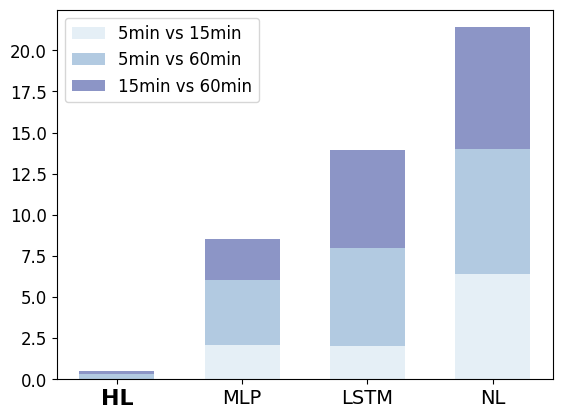

In [8]:
all_model_mce = all_model_mce.sort_values(by = "15min vs 60min", axis=1)
all_model_mce = all_model_mce.rename(columns={"Neural Laplace":"NL"})
# all_model_mce.to_csv("wind_mce.csv")
colors = plt.cm.BuPu(np.linspace(0.1, 0.5, len(all_model_mce)))
n_rows = len(all_model_mce)

index = np.arange(len(all_model_mce.columns))
bar_width = 0.6

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(all_model_mce.columns))

fig, ax=plt.subplots()
# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(all_model_mce.columns, all_model_mce.iloc[row, :], bar_width, bottom=y_offset, color=colors[row], label=all_model_mce.index[row])
    y_offset = y_offset + all_model_mce.iloc[row, :]

ax.legend(fontsize=12)
for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_fontsize(14)

    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(16)

for i, tick in enumerate(ax.get_yticklabels()):
    tick.set_fontsize(12)
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
# fig.savefig("savings/mce_wind.pdf",bbox_inches="tight")
